In [1]:
%matplotlib inline

# This example show you how to train a classifier using pytorch framework:


## step
--------------------
0. check your device
1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function and optimizer
4. Train the network
5. Test the network on the test data
--------------------


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

########################################################################
## 0. check your device

In the beginning, you have to be sure you have your gpu device available.

    [Remark] if you want to utilize GPUs for computation, you should check your system supports to CUDA.
    (refer the following step)

    [Remark] Pytorch have two types of tensor, one is CPU tensor types, another is CUDA tensor types. 
    GPU only can use CUDA tensor types for computation. 

-[Official document]: https://pytorch.org/docs/stable/cuda.html
########################################################################

In [3]:
#To determine if your system supports CUDA
print("==> Check devices..")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Current device: ",device)

#Also can print your current GPU id, and the number of GPUs you can use.
print("Our selected device: ", torch.cuda.current_device())
print(torch.cuda.device_count(), " GPUs is available")

==> Check devices..
Current device:  cuda
Our selected device:  0
1  GPUs is available


########################################################################
## 1. Load and normalizing the CIFAR10 training and test datasets using torchvision


1.1     Before building the dataset, knowing how to do data preprocessing is very important. Pytorch provides a package called "torchvision", it consists of some functions for image transformation, like: normalization, rotation, resize...etc., or if the provided functions didn't meet the needs, you can to use other libraries or tools to preprocess the data.
   

1.2     Pytorch provides a class called "dataset", you can create a subclass of it to format your raw data to a more suitable format for DataLoader. Fortunately, pytorch provided some popular datasets, model architectures, and functions of image transformation in "torchvision".


    [Remark] If you want to build a pytorch dataset for your own data. One you can do is rewriting a new subclass of original dataset class, and anothor is using the API called "ImageFolder" to load your dataset. The return of the "ImageFolder" is also a pytorch dataset class. However, you should adjust the directory architecture to match the need of "ImageFolder".

    [Remark] Study the document about "ImageFolder" is useful for your [LAB 1-2] 


1.3     After defining "Dataset" class, you can start to define a "DataLoader" class. You can easily to do "Minibatch training" by DataLoader. "Minibatch training" means DataLoader will separate your dataset into several batch. And each batch consists fixed number of data depend on what batch size you set.


-[How to load common dataset]: https://pytorch.org/docs/stable/torchvision/datasets.html

-[How to use ImageFolder]: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#afterword-torchvision

-[torchvision document]: https://pytorch.org/docs/stable/torchvision/index.html

-[torchvision sourcecode]: https://github.com/pytorch/vision/tree/master/torchvision

-[Dataset, DataLoader, DataLoaderIter document]: https://pytorch.org/docs/stable/data.html

-[Dataset, DataLoader, DataLoaderIter sourcecode]: https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#Dataset

########################################################################

In [4]:
print('==> Preparing dataset..')

==> Preparing dataset..


In [5]:
"""1.1"""
# The output of torchvision datasets are PILImage images of range [0, 1]
# We transform them to Tensor type
# And normalize the data
# Be sure you do same normalization for your train and test data

#The transform function for train data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#The transform function for test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [6]:
"""1.2""" 

path = '../data'
#Use API to load CIFAR10 train dataset
#trainset = torchvision.datasets.CIFAR10(root='/tmp/dataset-nctu', train=True, download=False, transform=transform_train)
trainset = torchvision.datasets.CIFAR10(root=path, train=True, download=True, transform=transform_train)

#Use API to load CIFAR10 test dataset
#testset = torchvision.datasets.CIFAR10(root='/tmp/dataset-nctu', train=False, download=False, transform=transform_test)
testset = torchvision.datasets.CIFAR10(root=path, train=False, download=True, transform=transform_test)

#The "download" option must be False in this Lab
#The cifar10 dataset we will provide in this path: /tmp/dataset-nctu
#Dataset definition need to know your customized transform function

Files already downloaded and verified
Files already downloaded and verified


In [7]:
"""1.3"""

#Create DataLoader to draw samples from the dataset
#In this case, we define a DataLoader to random sample our dataset. 
#For single sampling, we take one batch of data. Each batch consists 4 images
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=1,
shuffle=False, num_workers=2)

In [8]:
#Because cifar10 number the data classes in range [0,10]
#However, number representation is unreadable for humans
#So, we manually set the name of each class
classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

########################################################################

# 2. Define a Convolution Neural Network
    
Neural networks can be constructed using the "torch.nn" package, "torch.nn" depends on "autograd" to define model. A complete model definition contains layers declaration and forwarding methods.

    
All the model in pytorch inherit the "nn.Module" class. You can define new layer via "torch.nn" library. And, concatenate these layers into a complete model.


-[How to use nn.Module] https://pytorch.org/docs/stable/nn.html#torch.nn.Module

########################################################################

In [9]:
print('==> Building model..')

==> Building model..


In [10]:
import torch.nn as nn

In [11]:
# define your own model
class Net(nn.Module):

    def weight_constant(weight, c=0):
        nn.init.constant_(weight, c)

    def weight_uniform(weight, a=-1, b=1):
        nn.init.uniform_(weight, a, b)

    def weight_normal(weight, mean=0, std=1):
        nn.init.normal_(weight, mean=0, std=1)
    
    #define the layers
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()
        
    #concatenate these layers
    def forward(self, x):
        nn.init.normal_(self.conv1.weight, 0, 0.01)
        nn.init.normal_(self.conv1.bias, 0, 0.1)
        x = self.pool(self.relu(self.conv1(x)))
        nn.init.normal_(self.conv2.weight, 0, .01)
        nn.init.normal_(self.conv2.bias, 0, .1)
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        nn.init.normal_(self.fc1.weight, 0, .01)
        nn.init.normal_(self.fc1.bias, 0, .1)
        x = self.relu(self.fc1(x))
        nn.init.normal_(self.fc2.weight, 0, .01)
        nn.init.normal_(self.fc2.bias, 0, .1)
        x = self.relu(self.fc2(x))
        nn.init.normal_(self.fc3.weight, 0, .01)
        nn.init.normal_(self.fc3.bias, 0, .1)
        x = self.fc3(x)
        return x

In [13]:
# declare a new model
tmp_net = Net()
# now, you can see current model architecture
print(tmp_net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)


In [14]:
# or take a look at one layer of model
print(tmp_net.conv1)

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))


In [15]:
# you also can change the layer of model
# but can't edit the forward method
tmp_net.fc3 = nn.Linear(15,2)
print(tmp_net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=15, out_features=2, bias=True)
  (relu): ReLU()
)


In [16]:
# just edit the parameter of one layer is OK
tmp_net.fc3.out_features = 10
print(tmp_net)

# [Remark] above two method to change the layer
# architecture is important in [LAB 1-2]

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=15, out_features=10, bias=True)
  (relu): ReLU()
)


In [17]:
#declare a new model
net = Net()
# change all model tensor into cuda type
# something like weight & bias are the tensor 
if device == 'cuda':
    net = net.cuda(0)
else:
    net = net.cpu()

########################################################################

# 3. Define a Loss function and optimize

########################################################################

In [18]:
print('==> Defining loss function and optimize..')

==> Defining loss function and optimize..


In [19]:
import torch.optim as optim

#loss function
criterion = nn.CrossEntropyLoss()
#optimization algorithm
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

########################################################################

# 4. Train the network

Before training the model, we need to analysis the tensor variable.


Each variable have many attibute, like: .grad_fn, .require_grad, .data, .grad...etc. The ".grad_fn" attribute of "torch.Tensor" is an entry point into the function that has create this "torch.Tensor" variables. Because of ".grad_fn" flag, we can easily create a computing graph in the form of DAG(directed acyclic graph).

And then, the ".require_grad" attribute allows us to determine whether the backward propagation function is going to calculate the gradient of this "torch.Tensor" variable. If one variable has a false value of require_grad, it represent that you don't want to calculate this variable's gradient, and also its gradient will not be updated.

########################################################################

In [20]:
print('==> Training model..')

==> Training model..


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def show_weight_distribution(epoch):
    n_bins = 50
    font_size = 8
    plt.rcParams.update({'axes.titlesize': font_size})
    plt.rcParams.update({'axes.labelsize': font_size})
    plt.rcParams.update({'xtick.labelsize': font_size})
    plt.rcParams.update({'ytick.labelsize': font_size})
    fig, axs = plt.subplots(1, 5, sharey=True)
    
    x = net.conv1.weight.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 5, 1)
    plt.hist(x, bins=n_bins)
    plt.xlabel('conv1')
    plt.title('Weight Distribution, epoch: %d' %(epoch))

    x = net.conv2.weight.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 5, 2)
    plt.hist(x, bins=n_bins)
    plt.xlabel('conv2')

    x = net.fc1.weight.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 5, 3)
    plt.hist(x, bins=n_bins)
    plt.xlabel('fc1')

    x = net.fc2.weight.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 5, 4)
    plt.hist(x, bins=n_bins)
    plt.xlabel('fc2')

    x = net.fc3.weight.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 5, 5)
    plt.hist(x, bins=n_bins)
    plt.xlabel('fc3')

    plt.show()

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def show_bias_distribution(epoch):
    n_bins = 50
    font_size = 8
    plt.rcParams.update({'axes.titlesize': font_size})
    plt.rcParams.update({'axes.labelsize': font_size})
    plt.rcParams.update({'xtick.labelsize': font_size})
    plt.rcParams.update({'ytick.labelsize': font_size})
    fig, axs = plt.subplots(1, 5, sharey=True)
    
    x = net.conv1.bias.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 5, 1)
    plt.hist(x, bins=n_bins)
    plt.xlabel('conv1')
    plt.title('Bias Distribution, epoch: %d' %(epoch))

    x = net.conv2.bias.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 5, 2)
    plt.hist(x, bins=n_bins)
    plt.xlabel('conv2')

    x = net.fc1.bias.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 5, 3)
    plt.hist(x, bins=n_bins)
    plt.xlabel('fc1')

    x = net.fc2.bias.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 5, 4)
    plt.hist(x, bins=n_bins)
    plt.xlabel('fc2')

    x = net.fc3.bias.view(-1,1).cpu().detach().numpy()
    plt.subplot(1, 5, 5)
    plt.hist(x, bins=n_bins)
    plt.xlabel('fc3')

    plt.show()

1 epoch, training accuracy: 9.9700%, loss = 2.3073


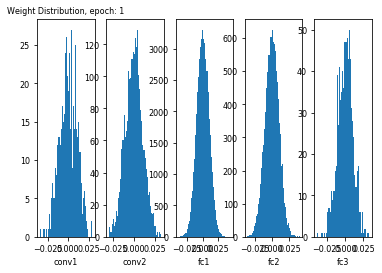

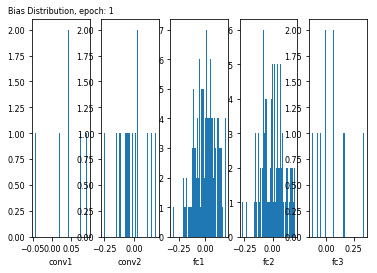

Finished Training


In [23]:
#Set the model in training mode
#because some function like: dropout, batchnorm...etc, will have 
#different behaviors in training/evaluation mode
#[document]: https://pytorch.org/docs/stable/nn.html#torch.nn.Module.train
net.train()

for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        
        #change the type into cuda tensor 
        inputs = inputs.cuda(0)
        labels = labels.cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        # select the class with highest probability
        _, pred = outputs.max(1)
        # if the model predicts the same results as the true
        # label, then the correct counter will plus 1
        correct += pred.eq(labels).sum().item()
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('%d epoch, training accuracy: %.4f%%, loss = %.4f' %
        (epoch+1, 100.*correct/len(trainset), running_loss/len(trainset)))
    show_weight_distribution(epoch+1)
    show_bias_distribution(epoch+1)
    
print('Finished Training')

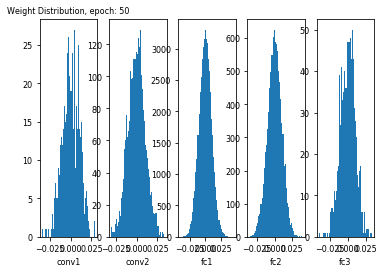

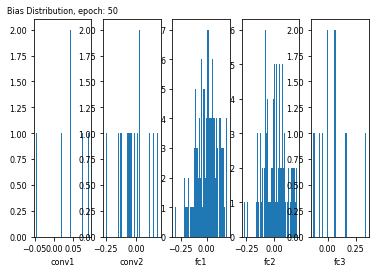

In [24]:
show_weight_distribution(50)
show_bias_distribution(50)

In [25]:
#After training , save the model first
#You can saves only the model parameters or entire model
#Some difference between the two is that entire model 
#not only include parameters but also record hwo each 
#layer is connected(forward method).
#[document]: https://pytorch.org/docs/master/notes/serialization.html

print('==> Saving model..')

#only save model parameters
torch.save(net.state_dict(), './checkpoint.t7')
#you also can store some log information
state = {
    'net': net.state_dict(),
    'acc': 100.*correct/len(trainset),
    'epoch': 75
}
torch.save(state, './checkpoint.t7')

#save entire model
torch.save(net, './model.pt')

print('Finished Saving')

==> Saving model..
Finished Saving


/home/ccma/anaconda3/lib/python3.5/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


########################################################################

# 5. Test the network on the test data

########################################################################

In [26]:
#Before testing, we can load the saved model
#Depend on how you save your model, need 
#different way to use it

print('==> Loading model..')

#If you just save the model parameters, you
#need to redefine the model architecture, and
#load the parameters into your model
net = Net()
checkpoint = torch.load('./checkpoint.t7')
net.load_state_dict(checkpoint['net'])

#If you save the entire model
net = torch.load('./model.pt')

print('Finished Loading')

==> Loading model..
Finished Loading


In [27]:
print('==> Testing model..')

#Set the model in evaluation mode
#[document]: https://pytorch.org/docs/stable/nn.html#torch.nn.Module.eval 
net.eval()


==> Testing model..


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)

In [28]:
######################
#######LAB 1-1########
"""
To Do Here

        You should complete the testing step in LAB 1-1
You should show the total accuracy & loss [10000 cifar10 test cases]
  You also need to tell us, how about the accuracy for each class
 
    For example: Total accuracy is: 60.0% and loss is: 0.02  
                 For each class in cifar 10:
                 Accuracy of plane : 58.0%
                 Accuracy of   car : 22.4%
                            .
                            .
                            .
"""
######################
correct = 0
total = 0
running_loss = 0.0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data

        if device == 'cuda':
            images = images.cuda(0)
            labels = labels.cuda(0)
        else:
            images = images.cpu()
            labels = labels.cpu()
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        c = (predicted == labels).squeeze()
        #print(predicted)
        #print(labels.size(0))
        #print(c)
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the %d test images: %.2f%%, and loss is: %.3f'
      % (total, 100 * correct / total, running_loss / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/home/ccma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Accuracy of the network on the 10000 test images: 9.89%, and loss is: 2.308
Accuracy of plane :  8 %
Accuracy of   car : 10 %
Accuracy of  bird : 10 %
Accuracy of   cat : 10 %
Accuracy of  deer : 10 %
Accuracy of   dog :  8 %
Accuracy of  frog : 11 %
Accuracy of horse : 10 %
Accuracy of  ship :  8 %
Accuracy of truck :  9 %
